# Modelling and conclusions
In this notebook I will:
+ Re-run the models and compare it to the
    + Baseline model
    + Best regression model in notebook 03_EDA_and Visualisations
+ Compare the models progress
+ Discuss the model choice and evaluation


### Contents:
- [Data Import](#Data-Import)
- [Model Discussion](#Model-Discussion)
- [Run Model](#Run-Model)
- [Model Iterations and improvements](#Model-Iterations-and-improvements)
- [Interpreting Results](#Model-Interpretation)
- [Kaggle Submission](#Kaggle-Submission)

# Data Import

In [703]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

#### Get Data

In [704]:
ames_train = pd.read_csv('./datasets/outputs/final_train.csv')
ames_test = pd.read_csv('./datasets/outputs/final_test.csv')

In [705]:
ames_train.shape, ames_test.shape

((2051, 226), (879, 225))

In [706]:
# chek no nulls in train
ames_train.isnull().sum().sort_values(ascending=False).head(5)

ht_Floor    0
mo_sold     0
str_Pave    0
str_Grvl    0
msz_RM      0
dtype: int64

In [707]:
# chek no nulls in test
ames_test.isnull().sum().sort_values(ascending=False).head(5)

nbd__Landmrk    0
cd2_PosN        0
aly_None        0
aly_Grvl        0
str_Pave        0
dtype: int64

---

# Model Discussion

I have chosen to use the following models:
+ Linear Regression
    + Multiple Linear Regression - No Regularisation penalty
    
    
    + Multiple Linear Regression - Lasso Regularisation penalty
        + A harsh penalty which brings coefficients down to 0 when there impact is limited
        
        
    + Multiple Linear Regression - Ridge Regularisation penalty
        + A slightly softer penalty but still penalises high coefficients and reduces there impact
        
        
    + Multiple Linear Regression - ElasticNet Regularisation penalty
        + This uses a ratio of both L1 and L2 which is a nice way of making sure the better of the two approach is chosen
        
        
My data cleaning and decisions have been based on trying to keep as much data as possible. This approach is because I think its important not to fabricate or remove valid data points. However this leaves many features in the model. I think ElasticNet and L1 and L2 offer a great way to help decide which features are important and which ones arent. The result is they are effectively dropped by the model when the coefficient reaches 0.



## Feature Selection and creation

As per my plan I used as many features as I could in the model. This was planned and I expected that Lasso and ElasticNet penalties would naturally remove unimportant features.

However I found that over fitting was occuring and a good performance on the training set was not being matched on the test set.

Therefore I removed columns that were similar and had a strong correlation and columns that I deduced as less important. These columns were:

+ 'sale_type'
+ 'roof_matl'
+ 'roof_style'
+ 'paved_drive'
+ 'misc_features'
+ 'garage_cars'

#### Column creation

As per notebook 04_One hot encoding and feature engineering, I created features by turnig ordinal data into scales by using dictionaries to match the category values to corresponding numbers.

I also created dummy columns for the other categorical data which didnt have a scale. This is important as some features presence may be important. However if its not one hot encoded then it will be missed.

##  Grid Search

I have not used grid search becuase the LassoCV, RidgeCV and ElasticNetCV provide the same functionality as the grid search. However it is a more efficient algorithm in this case. Therefore I would have no extra beneft but at a cost.

##  Metrics

The initial models return
+ r2 the models return the coefficient of determination R^2 of the prediction.

I also convert the final model into
+ RMSE - Root Means Squared Error - requested metric for the assignment

Both are popular metrics to compare and standardise the errors and makke model comparisons easier. However they both are score well when the accuracy improves. The smaller the residuals or difference between yhat and y leads to better scores.


### Problems
They are both good measures but unless you use cross validation they are prone to overfitting. They could provide a good score on a certain data split. However this may vary drastically on another. Therefore to reduce this I will split the data up using cross val splits of 5 and take an average of the performance of the models.


# Run Model

In [708]:
type(ames_train['mo_sold'][0])

numpy.int64

In [709]:
ames_train.select_dtypes(exclude=['object'])

,id,pid,lot_frontage,lot_area,utilities,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,nbd__SawyerW,nbd__Somerst,nbd__StoneBr,nbd__Timber,nbd__Veenker,ext1_PreCast,ext2_Other,ext2_PreCast,mvt_CBlock,ht_Floor
0,109,533352170,13517.0,13517.0,2,6,8,1976,2005,289.0,...,0,0,0,0,0,0,0,0,0,0
1,544,531379050,43.0,11492.0,2,7,5,1996,1997,132.0,...,1,0,0,0,0,0,0,0,0,0
2,153,535304180,68.0,7922.0,2,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,0
3,318,916386060,73.0,9802.0,2,5,5,2006,2007,0.0,...,0,0,0,1,0,0,0,0,0,0
4,255,906425045,82.0,14235.0,2,6,8,1900,1993,0.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,79.0,11449.0,2,8,5,2007,2007,0.0,...,0,0,0,1,0,0,0,0,0,0
2047,785,905377130,12342.0,12342.0,2,4,5,1940,1950,0.0,...,0,0,0,0,0,0,0,0,0,0
2048,916,909253010,57.0,7558.0,2,6,6,1928,1950,0.0,...,0,0,0,0,0,0,0,0,0,0
2049,639,535179160,80.0,10400.0,2,4,5,1956,1956,0.0,...,0,0,0,0,0,0,0,0,0,0


In [710]:
# Create a list of features that will be used in the model

train_features = [col for col in ames_train._get_numeric_data().columns if col != 'saleprice' 
                                                                              and col != 'id' 
                                                                              and col != 'pid'
                                                                              and col != 'sale_type'
                                                                              and col != 'roof_matl'
                                                                              and col != 'roof_style'
                                                                              and col != 'paved_drive'
                                                                              and col != 'misc_features'
                                                                              and col != 'garage_cars'
                                                                              and col != '1st_flr_sf'
                                                                              and col != '2nd_flr_sf']

In [711]:
# Setup the features
X = ames_train[train_features]
y = ames_train['saleprice']

In [712]:
# Split the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [713]:
# Scale the data
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [714]:
# Setup our models

lr_dm = LinearRegression()
lasso_dm = LassoCV(n_alphas=200, max_iter=10000)
ridge_dm = RidgeCV(alphas=np.linspace(0.1,10,100))
enet_dm = ElasticNetCV(l1_ratio=np.linspace(0.0001,1,50), n_alphas = 200, max_iter=10000)

In [715]:
### Run the different models and compare

lr_scores = cross_val_score(lr_dm, X_train, y_train, cv=20)
lr_scores.mean()

-1.0467664710800547e+25

In [716]:
lasso_scores = cross_val_score(lasso_dm, X_train, y_train)
lasso_scores, lasso_scores.mean()

(array([0.87518245, 0.90847383, 0.89322758, 0.84675122, 0.87373995]),
 0.8794750065997814)

In [717]:
ridge_scores = cross_val_score(ridge_dm, X_train, y_train)
ridge_scores.mean()

0.869438962528735

In [718]:
enet_scores = cross_val_score(enet_dm, X_train, y_train)
enet_scores.mean()

0.8794750065997814

In [719]:
enet_scores.mean() >= lasso_scores.mean() >  ridge_scores.mean() > lr_scores.mean()

True

I chose Enet as it was performing the best. However in the last run it shifted. Overall it is the better choice because it should default to be at least as good as either L1 or L2 as it applies a ratio 

In [720]:
# fit on all training data and then predict the test data
enet_dm.fit(X_train, y_train)
yhat = enet_dm.predict(X_test)

Text(0.5, 0, 'Predictions')

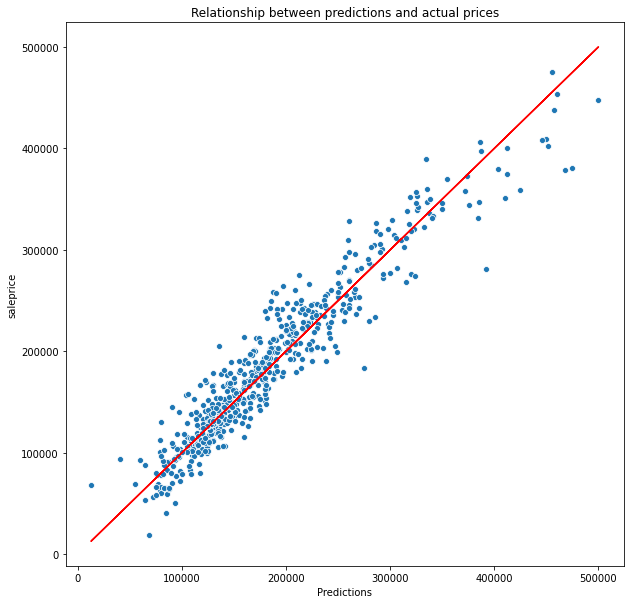

In [721]:
# Plot to show the correlation between prediction and value.
f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(y_test, yhat);
ax.plot(y_test.min(), y_test.max(),
        y_test, y_test, color='r');
plt.title("Relationship between predictions and actual prices") 
plt.ylabel("saleprice")
plt.xlabel("Predictions") 

#### Observations

There is a good correlation between the predictions. My predictions tend to under evaluate the more expensive houses.

In [722]:
# RMSE Score

np.sqrt(mean_squared_error(y_test, yhat))

23220.379969461264

In [723]:
enet_dm.score(X_test, y_test)

0.9102360068087514

In [724]:
residuals = y_test - yhat

Text(0.5, 0, 'Predictions')

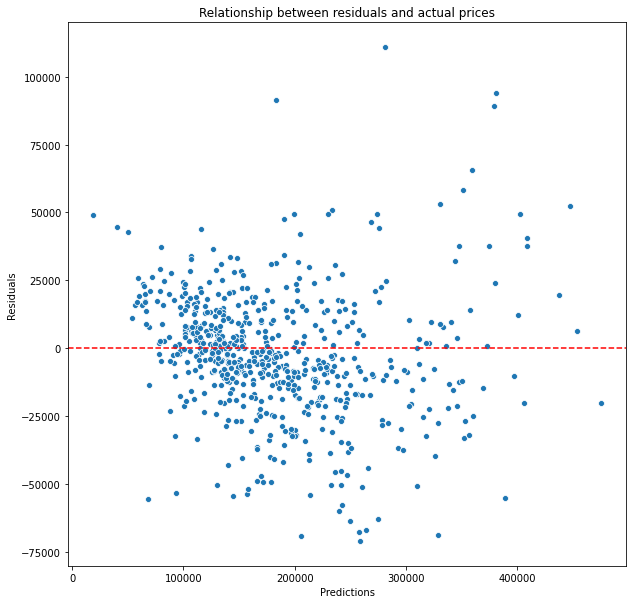

In [725]:
#plt.scatter(yhat, residuals);

f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(yhat, residuals);
ax.axhline(0, ls='--', color='r')
plt.title("Relationship between residuals and actual prices") 
plt.ylabel("Residuals")
plt.xlabel("Predictions")

The graph above shows the majority of points are spread evenly above and below zero. This shows that there is not too much affect at either smaller or larger ranges.

In [726]:
### Get the coefficients

feature_df = pd.DataFrame(enet_dm.coef_, index=train_features)
feature_df.rename(columns={0:'coef'}, inplace=True)
feature_df.reset_index(inplace=True)
feature_df.sort_values('coef',ascending=False, inplace=True)
feature_df.rename(columns={'index':'feature'}, inplace=True)

# Model Iterations and improvements

The model has improved throught he stages:


+ Baseline: RMSE 79239.3


+ First run: Lasso: RMSE 31146.9


+ Final: RMSE 23220.4

My plan was to iterate through models and see improvements and these scores show it has been successful

# Model-Interpretation

### Investigate coefficients and visualise results

In [727]:
# create a dataframe with top 10 features and bottom 10 features
feature_df_key = pd.concat([feature_df.head(10),feature_df.tail(10)], ignore_index=True)

feature_col_names = feature_df_key['feature']


In [760]:
feature_col_names_dict = {
        'gr_liv_area':'Above Ground Living Area',
        'overall_qual':'Overall Quality',
        'nbd__NridgHt':'Northridge Heights',
        'lot_area':'Land Area',
        'kitchen_qual':'Kitchen Quality',
        'nbd__StoneBr':'Stone Brook',
        'exter_qual':'External Quality',
        'nbd__NoRidge':'Northridge',
        'bd_ty_1Fam':'Single-family Detached',
        'bsmt_exposure':'Basement Exposure',
        'ext1_Wd Sdng':'Primarily Wood Siding',
        'ext2_Stucco':'Secondary Stucco',
        'ht_OthW':'Not gas powered heating',
        'ext1_Stucco':'Primarily External Stucco',
        'nbd__Edwards':'Edwards',
        'ms_sub_120':'Planned Unit Development',
        'pool_qc':'Pool Quality',
        'lot_frontage':'Amount of street attached to property',
        'lts_IR3':'Irregular Lot Shape',
        'misc_val':'Miscellaneous Feature Value',
        'hs_sty_1Story':'One story house',
        'bsmtfin_sf_1':'Type 1 Basement: quality sqft',
        'ms_sub_150':'1-1/2 Story Planned Unit Development',
        'hs_sty_2Story':'Two story house',
        'ms_sub_160':'2-Story Planned Unit Development',
        'bedroom_abvgr':'Bedrooms above ground level',
        'fd_CBlock':'Cinder Block Foundation'
}

In [761]:
feature_df_key.replace({"feature": feature_col_names_dict},inplace=True) 

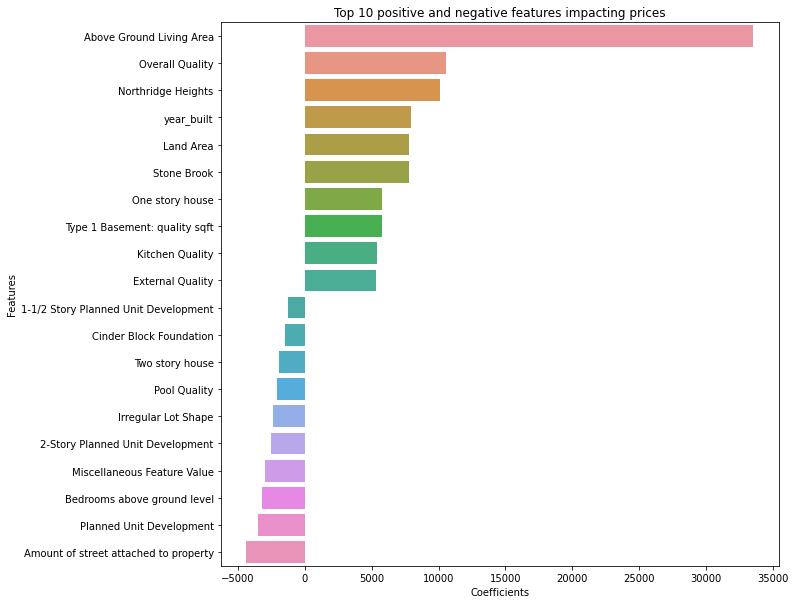

In [762]:
# Plot the graph to show top and bottom features.

f, ax = plt.subplots(figsize=(10,10))
sns.barplot(feature_df_key['coef'],feature_df_key['feature']);
plt.title("Top 10 positive and negative features impacting prices") 
plt.ylabel("Features")
plt.xlabel("Coefficients") ;

This graph shows that these are the key factors to increasing price:

+ ground living area
+ overall quality
+ lot area kitchen quality 
+ living in Northridgholt 

Conversely it shows that these are the key factors that inversely affect the price:

+ Planned units have a penalty
+ Irregular plots are discounted
+ Amount of street attached to property comes with a penalty


### Neighborhood analysis

Investigate the neighborhoods to see where they rank

In [731]:
# Create Neighborhoods dictionary to enable clearer plots
neighborhood_dict = {'nbd__Blmngtn':'Bloomington Heights',
                    'nbd__Blueste':'Bluestem',
                    'nbd__BrDale':'Briardale',
                    'nbd__BrkSide':'Brookside',
                    'nbd__ClearCr':'Clear Creek',
                    'nbd__CollgCr':'College Creek',
                    'nbd__Crawfor':'Crawford',
                    'nbd__Edwards':'Edwards',
                    'nbd__Gilbert':'Gilbert',
                    'nbd__IDOTRR':'Iowa DOT and Rail Road',
                    'nbd__MeadowV':'Meadow Village',
                    'nbd__Mitchel':'Mitchell',
                    'nbd__Names':'North Ames',
                    'nbd__NoRidge':'Northridge',
                    'nbd__NPkVill':'Northpark Villa',
                    'nbd__NridgHt':'Northridge Heights',
                    'nbd__NWAmes':'Northwest Ames',
                    'nbd__OldTown':'Old Town',
                    'nbd__SWISU':'South & West of Iowa State University',
                    'nbd__Sawyer':'Sawyer',
                    'nbd__SawyerW':'Sawyer West',
                    'nbd__Somerst':'Somerset',
                    'nbd__StoneBr':'Stone Brook',
                    'nbd__Timber':'Timberland'}

In [732]:
nbd_cols = [k for k,v in neighborhood_dict.items()]

In [733]:
# update neighbourhood columns
nbhd_analysis_df = feature_nbhd_df[feature_nbhd_df['feature'].isin(nbd_cols)]
nbhd_analysis_df = nbhd_analysis_df.replace({"feature": neighborhood_dict}) 

In [734]:
filtered_nbhd_feats = nbhd_analysis_df.loc[nbhd_analysis_df['coef']!=0,['feature','coef']]

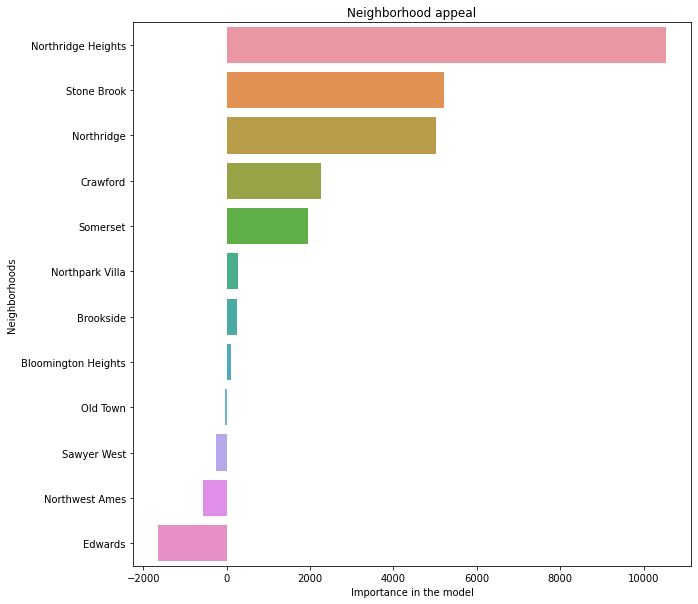

In [735]:
# Create a graph for the Neighborhoods
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(filtered_nbhd_feats['coef'],filtered_nbhd_feats['feature']);
plt.title("Neighborhood appeal") 
plt.ylabel("Neighborhoods")
plt.xlabel("Importance in the model") ;

Look at average sales price price per neighborhood for context

In [795]:
original_data = pd.read_csv('./datasets/inputs/train.csv')

In [799]:
# Create Neighborhoods dictionary to enable clearer plots
neighborhood_dict = {'Blmngtn':'Bloomington Heights',
                    'Blueste':'Bluestem',
                    'BrDale':'Briardale',
                    'BrkSide':'Brookside',
                    'ClearCr':'Clear Creek',
                    'CollgCr':'College Creek',
                    'Crawfor':'Crawford',
                    'Edwards':'Edwards',
                    'Gilbert':'Gilbert',
                    'IDOTRR':'Iowa DOT and Rail Road',
                    'MeadowV':'Meadow Village',
                    'Mitchel':'Mitchell',
                    'Names':'North Ames',
                    'NoRidge':'Northridge',
                    'NPkVill':'Northpark Villa',
                    'NridgHt':'Northridge Heights',
                    'NWAmes':'Northwest Ames',
                    'OldTown':'Old Town',
                    'SWISU':'South & West of Iowa State University',
                    'Sawyer':'Sawyer',
                    'SawyerW':'Sawyer West',
                    'Somerst':'Somerset',
                    'StoneBr':'Stone Brook',
                    'Timber':'Timberland'}

nbhd_df = pd.DataFrame()

means = original_data.groupby('Neighborhood')['SalePrice'].mean()

nbhd_df = pd.DataFrame()
nbhd_df['av_price'] = means

nbhd_df.reset_index(level='Neighborhood', inplace=True)
nbhd_df.replace({"Neighborhood": neighborhood_dict}, inplace=True) 
nbhd_df = nbhd_df.sort_values(by='av_price', ascending=False)

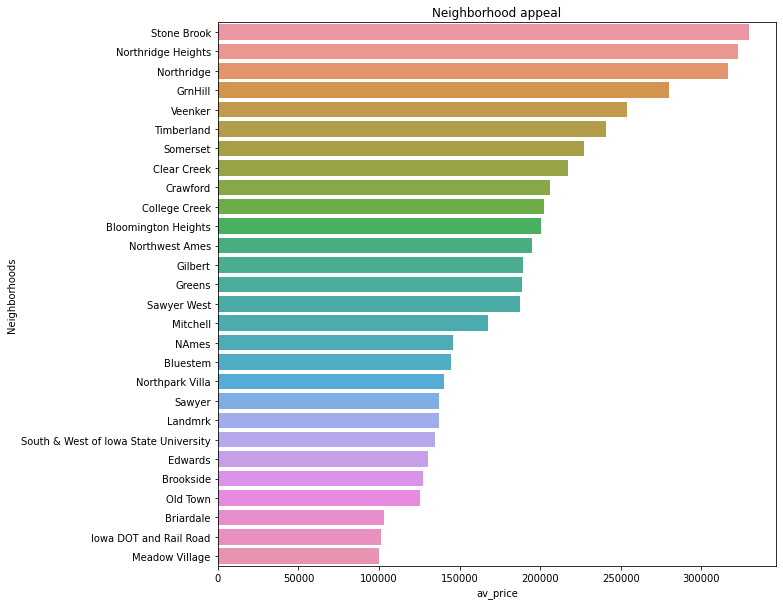

In [800]:
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(y=nbhd_df['Neighborhood'], x=nbhd_df['av_price']);
plt.title("Neighborhood appeal") 
plt.ylabel("Neighborhoods");



### Investigate best month to sell and best month to buy

In [763]:
month_sales = ames_train.groupby(by='mo_sold')['saleprice'].mean()
month_sales

mo_sold
1     195126.303797
2     177626.519231
3     174625.779762
4     163901.269231
5     180332.369650
6     182662.798295
7     188571.514851
8     186927.359281
9     188990.761468
10    179334.471545
11    184377.495146
12    182459.615385
Name: saleprice, dtype: float64

In [764]:
month_volumes = ames_train.groupby(by='mo_sold')['saleprice'].size()
month_volumes

mo_sold
1      79
2     104
3     168
4     208
5     257
6     352
7     303
8     167
9     109
10    123
11    103
12     78
Name: saleprice, dtype: int64

In [765]:
month_data = pd.DataFrame()
month_data['month'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_data['av_price'] = list(month_sales/1000)
month_data['sales'] = list(month_volumes)

month_data

,month,av_price,sales
0,Jan,195.126304,79
1,Feb,177.626519,104
2,Mar,174.625780,168
3,Apr,163.901269,208
4,May,180.332370,257
5,Jun,182.662798,352
6,Jul,188.571515,303
7,Aug,186.927359,167
8,Sep,188.990761,109
9,Oct,179.334472,123


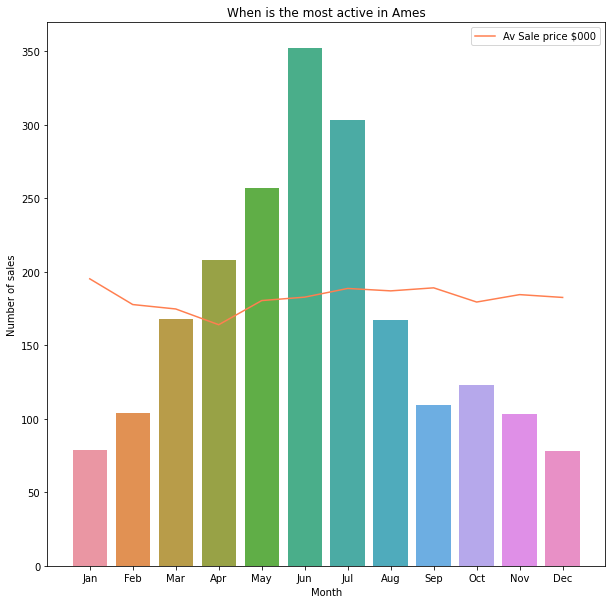

In [742]:
# plot number of Sales and av price per month
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(month_data['month'],month_data['sales'])
sns.lineplot(data=month_data["av_price"], color="coral", label="Av Sale price $000")
plt.xlabel('Month')
plt.ylabel('Number of sales')
plt.title('When is the most active in Ames');


### External features

Least and most popular

In [766]:
# Description: Exterior covering on house
# Exterior dictionary

exterior_dict = {
    'ext1_AsbShng':'Asbestos Shingles',
    'ext1_AsphShn':'Asphalt Shingles',
    'ext1_BrkComm':'Brick Common',
    'ext1_BrkFace':'Brick Face',
    'ext1_CBlock':'Cinder Block',
    'ext1_CemntBd':'Cement Board',
    'ext1_HdBoard':'Hard Board',
    'ext1_ImStucc':'Imitation Stucco',
    'ext1_MetalSd':'Metal Siding',
    'ext1_Other':'Other',
    'ext1_Plywood':'Plywood',
    'ext1_PreCast':'PreCast',
    'ext1_Stone':'Stone',
    'ext1_Stucco':'Stucco',
    'ext1_VinylSd':'Vinyl Siding',
    'ext1_Wd Sdng':'Wood Siding'
}

In [767]:
ext1_cols = [k for k,v in exterior_dict.items()]

In [768]:
# update neighbourhood columns
ext1_analysis_df = feature_df[feature_df['feature'].isin(ext1_cols)]
ext1_analysis_df = ext1_analysis_df.replace({"feature": exterior_dict}) 

In [769]:
filtered_ext_feats = ext1_analysis_df.loc[ext1_analysis_df['coef']!=0,['feature','coef']]

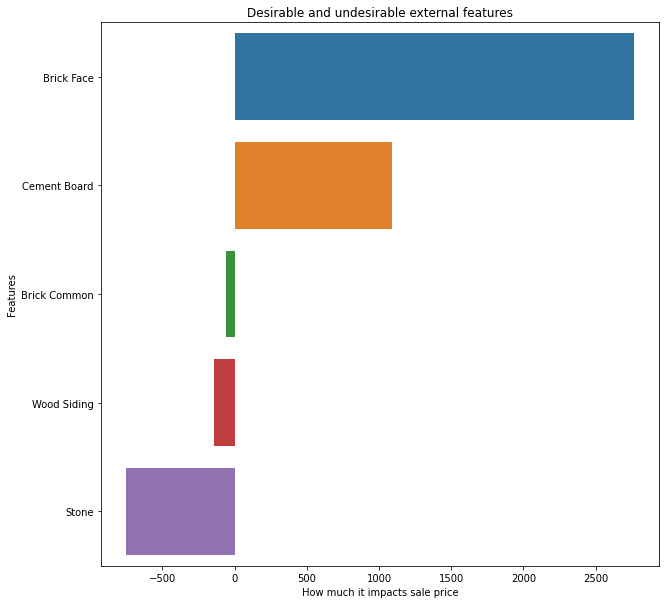

In [770]:
# Create a graph for the external features
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(filtered_ext_feats['coef'],filtered_ext_feats['feature']);
plt.title("Desirable and undesirable external features") 
plt.ylabel("Features")
plt.xlabel("How much it impacts sale price") ;

In [771]:
garage_type_df = feature_df.loc[feature_df['feature'].str.contains('^gar'),['feature','coef']]
garage_type_df

,feature,coef
35,garage_area,4657.212452
33,garage_yr_blt,-0.000000
36,garage_qual,-0.000000
37,garage_cond,-0.000000
34,garage_finish,-29.799016


In [772]:
basement_df = feature_df.loc[feature_df['feature'].str.contains('^bsmt'),['feature','coef']]
basement_df

,feature,coef
14,bsmtfin_sf_1,5751.533269
12,bsmt_exposure,5264.165170
10,bsmt_qual,3563.162085
22,bsmt_full_bath,2414.672403
13,bsmtfin_type_1,1247.929064
16,bsmtfin_sf_2,808.065076
17,bsmt_unf_sf,-0.000000
23,bsmt_half_bath,-0.000000
15,bsmtfin_type_2,0.000000
11,bsmt_cond,-404.007511


In [773]:
# Description: Basement factors
# Basement dictionary

basement_dict = {
    'bsmt_exposure':'Basment walkout or garden level walls',
    'bsmtfin_sf_1':'Type 1 Basement: quality sqft',
    'bsmt_qual':'Height of the basement',
    'bsmt_full_bath':'Basement full bathrooms',
    'bsmtfin_type_1':'Quality of basement finished area',
    'bsmtfin_sf_2':'Type 2 Basement: quality sqft',
    'bsmt_half_bath':'Basement half bathrooms',
    'bsmtfin_type_2':'Quality of basement finished area',
    'bsmt_unf_sf':'Unfinished sqft',
    'bsmt_cond':'General condition of the basement'
}

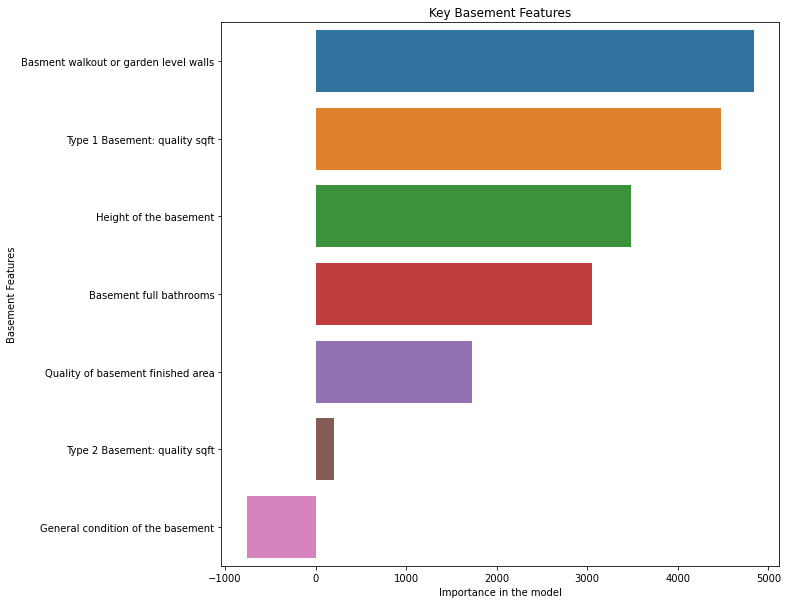

In [775]:
basement_cols = [k for k,v in basement_dict.items()]

# update neighbourhood columns
basement_analysis_df = feature_nbhd_df[feature_nbhd_df['feature'].isin(basement_cols)]
basement_analysis_df = basement_analysis_df.replace({"feature": basement_dict}) 

filtered_basement_feats = basement_analysis_df.loc[basement_analysis_df['coef']!=0,['feature','coef']]

# Create a graph for the Neighborhoods
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(filtered_basement_feats['coef'],filtered_basement_feats['feature']);
plt.title("Key Basement Features") 
plt.ylabel("Basement Features")
plt.xlabel("Importance in the model") ;

In [ ]:
# Create Neighborhoods dictionary to enable clearer plots
neighborhood_dict = {'Blmngtn':'Bloomington Heights',
                    'Blueste':'Bluestem',
                    'BrDale':'Briardale',
                    'BrkSide':'Brookside',
                    'ClearCr':'Clear Creek',
                    'CollgCr':'College Creek',
                    'Crawfor':'Crawford',
                    'Edwards':'Edwards',
                    'Gilbert':'Gilbert',
                    'IDOTRR':'Iowa DOT and Rail Road',
                    'MeadowV':'Meadow Village',
                    'Mitchel':'Mitchell',
                    'Names':'North Ames',
                    'NoRidge':'Northridge',
                    'NPkVill':'Northpark Villa',
                    'NridgHt':'Northridge Heights',
                    'NWAmes':'Northwest Ames',
                    'OldTown':'Old Town',
                    'SWISU':'South & West of Iowa State University',
                    'Sawyer':'Sawyer',
                    'SawyerW':'Sawyer West',
                    'Somerst':'Somerset',
                    'StoneBr':'Stone Brook',
                    'Timber':'Timberland'}

---

## Test Kaggle

In [348]:
test_features = [col for col in ames_test._get_numeric_data().columns if col != 'saleprice' 
                                                                              and col != 'id' 
                                                                              and col != 'pid'
                                                                              and col != 'sale_type'
                                                                              and col != 'roof_matl'
                                                                              and col != 'roof_style'
                                                                              and col != 'paved_drive'
                                                                              and col != 'misc_features'
                                                                              and col != 'garage_cars']

X = ames_test[test_features]

In [349]:
# Scale the data
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)

In [350]:
yhat = enet_dm.predict(X)

In [351]:
predictions = pd.DataFrame(columns=['Id','SalePrice'])

In [352]:
predictions['Id'] = ames_test['id']

In [353]:
predictions['SalePrice'] = yhat

In [354]:
#predictions.to_csv('./datasets/outputs/predictions2.csv', index=False)

---

## Kaggle Submisison

![Kaggle Submission and Score](images/kaggle_score.png "Kaggle Submission")